In [13]:
import dill
import gzip
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
sas_file = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/SASRec-vanilla.dill.gz"
bert_file = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/BERT4rec.dill.gz"
gsasrec_file = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/DebSASRec-samples:256-t:1.0.dill.gz"

model_sas = dill.load(gzip.open(sas_file))
model_bert = dill.load(gzip.open(bert_file))
model_gsas = dill.load(gzip.open(gsasrec_file))

2023-01-27 09:54:52.780649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 09:54:53.220077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-27 09:54:53.220112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-27 09:54:53.220115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-01-19 18:46:46      4327048
metadata.json                                  2023-01-19 18:46:46           64
config.json                                    2023-01-19 18:46:46          734


2023-01-27 09:54:55.124683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-01-27 09:54:55.160533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-27 09:54:55.216425: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-27 09:54:55.218575: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-01-27 09:54:55.218584: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at /usr/local/cuda/bin/ptxas
2023-01-27 09:54:55.218640: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:189] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...embedding_dropout
......vars
...item_embeddings_layer
......vars
.........0
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_6
.........vars
............0
............1
......dense_7
.........vars
............0
............1
......dense_8
.........vars
............0
............1
......dense_9
.........vars
............0
............1
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......dropout_4
.........vars
......embedding_1
.........vars
............0
......embedding_2
.........vars
............0
......layer_normalization
.........vars
............0
............1
......l

In [4]:
sas = model_sas.recommender
gsas = model_gsas.recommender
bert4rec = model_bert.recommender

In [5]:
users_to_test = np.random.choice(list(sas.users.straight.keys()), 5)

In [55]:
users_to_test

array(['963', '3560', '3933', '5153', '1836'], dtype='<U4')

In [6]:
scores_sas = []
scores_bert = []
scores_gsas=[]
for user in users_to_test:
    recs_sas=sas.recommend(user, 3416)
    distr_sas = [rec[1] for rec in recs_sas]
    scores_sas.append(distr_sas)
    
    recs_bert = bert4rec.recommend(user, 3416)
    distr_bert = [rec[1] for rec in recs_bert]
    scores_bert.append(distr_bert)
    
    recs_gsas = gsas.recommend(user, 3416)
    distr_gsas = [rec[1] for rec in recs_gsas]
    scores_gsas.append(distr_gsas)

In [7]:
import tensorflow as tf
scores_sas = tf.convert_to_tensor(scores_sas)
scores_bert = tf.convert_to_tensor(scores_bert)
scores_gsas = tf.convert_to_tensor(scores_gsas)

In [8]:
sas_probs = tf.sigmoid(scores_sas).numpy()
bert_probs = tf.math.softmax(scores_bert, axis=-1).numpy()
gsas_probs = tf.sigmoid(scores_gsas).numpy()

In [9]:
ranks = list(range(1, scores_sas.shape[1]+1))

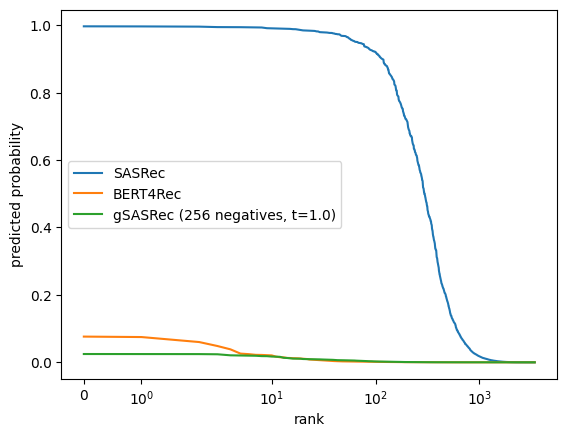

In [54]:
plt.xscale('symlog')
plt.xlabel('rank')
plt.ylabel('predicted probability')

plt.plot(sas_probs[0], label='SASRec')
plt.plot(bert_probs[0], label='BERT4Rec')
plt.plot(gsas_probs[0], label='gSASRec (256 negatives, t=1.0)')
plt.legend()


In [43]:
df = pd.DataFrame([ranks, sas_probs[0], bert_probs[0], gsas_probs[0]]).T
df.columns=["rank", "SASRec", "BERT4Rec", "gSASRec (256 negatives, t=1.0)"]
df['rank'] = df['rank'].astype('int32')
df = df.set_index('rank')

In [45]:
df.to_csv("predicted_probs.csv")